# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #4
**Harvard University**<br>
**Spring 2017**<br>
**Due Date: ** Thursday, Febrary 16th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [104]:
import numpy as np
import pandas as pd
from scipy import stats 
from scipy.stats import multivariate_normal
import time
import math
from functools import partial
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 1: Optimization (Continued)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A: Further problems with descent algorithms
Using your implementation of gradient descent and stochastic gradient descent, document the behaviour of your two algorithms for the following starting points, and for a number of stepsizes of your choice:
- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$

Based on your analysis of the lost function $L$, explain what is happening to your descent algorithms.

**Solutions:** Recall that our objective function, the total (or average) loss function, looks like:
$$
\mathrm{Total Loss} = \sum_{i=1}^N L(x_i, y_i, \lambda_1, \lambda_2).
$$
In Homework #3 we explored the impact of our choice of stepsize on our various gradient descent algorithms. In this homework we explore the impact of our choice of initialization in the parameter space.

Why would your choice of initial parameters matter? Let's recall our visualization of the objective function from Homework #3:

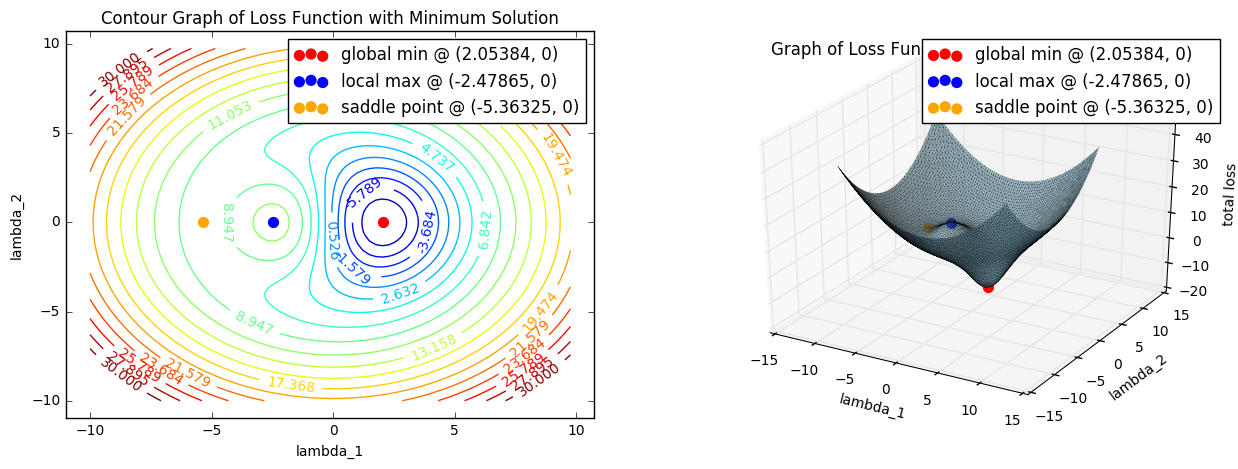

In [103]:
#Read the data
x, y = np.genfromtxt('HW3_data.csv', delimiter=',')

#Some constants we'll need
x_sum = x.sum()
y_sum = y.sum()
N = len(x)

#Total loss
L = lambda l1, l2, x, y: 0.000045 * l2**2 * y.sum() - 0.000098 * l1**2 * x.sum() + 0.003926 * x.sum() * l1 * np.exp(-0.1 * (l1**2 + l2**2))

#Cover the domain of the pdf with a grid and get the coordinates of the grid vertices
delta = 0.25
l1 = np.arange(-10, 10, delta)
l2 = np.arange(-10, 10, delta)
l1, l2 = np.meshgrid(l1, l2)
#The loss function evaluated at the vertices of the grid
loss = L(l1, l2, x, y)

fig = plt.figure(figsize=(15, 5))

#plot contour map of pdf with data in R^2 (Cartesian plane)
ax1 = fig.add_subplot(121) 
contour = ax1.contour(l1, l2, loss, levels=np.linspace(-10, 30, 20))
ax1.scatter([2.05384], [0], color='red', s=50, label='global min @ (2.05384, 0)')
ax1.scatter([-2.47865], [0], color='blue', s=50, label='local max @ (-2.47865, 0)')
ax1.scatter([-5.36325], [0], color='orange', s=50, label='saddle point @ (-5.36325, 0)')
ax1.clabel(contour, inline=1, fontsize=10)
ax1.set_title('Contour Graph of Loss Function with Minimum Solution')
ax1.set_xlabel('lambda_1')
ax1.set_ylabel('lambda_2')
ax1.legend(loc='best')

#plot 3D suface of pdf in R^3
ax2 = fig.add_subplot(122, projection='3d') 
ax2.plot_trisurf(l1.flatten(), l2.flatten(), loss.flatten(), linewidth=0.2, antialiased=True, color='skyblue', alpha=0.5, zorder=0)
ax2.scatter([2.05384], [0], [L(2.05384, 0, x, y)], color='red', s=50, label='global min @ (2.05384, 0)')
ax2.scatter([-2.47865], [0], [L(-2.47865, 0, x, y)], color='blue', s=50, label='local max @ (-2.47865, 0)')
ax2.scatter([-5.36325], [0], [L(-5.36325, 0, x, y)], color='orange', s=50, label='saddle point @ (-5.36325, 0)', zorder=10)
ax2.set_xlabel('lambda_1')
ax2.set_ylabel('lambda_2')
ax2.set_zlabel('total loss')
ax2.set_title('Graph of Loss Function with Minimum Solution')
ax2.legend(loc='best')

plt.show()

We see, from the above graphs, that our total loss function has three stationary points (points in the parameter space where the gradient of the total loss function is zero):

1. local and global minimum at approximately (2.05384, 0), with total loss -9.9341
2. local maximum at approximately (-2.47865, 0), with total loss 11.9546 
3. saddle point at approximately (-5.36325, 0), with total loss 8.16153 

At each of these points, since the gradient is very nearly zero, we'd expect gradient descent to be stationary (the algorithm will not make any updates to the parameters, since updates are proportional to the gradient vector). Thus, if gradient descent lands on either the local max or the saddle point during its path through the parameter space then it will not converge on the correct optimal value.

But how often can gradient descent get stuck at the local max or the saddle point? Since in every step of gradient descent, we update the parameter to decrease total loss, it is very unlikely that we will end up at the local max (if our initialization is not at the local max). On the other hand, if we are initialized on the left of the local max and along the straight line passing through the local max and the saddle point, then we are nearly guaranteed to land in the saddle point. The intuition is: if you initialize on the *right* side of the hill containing our local max, then we will "slide down" right into the global min, but if we initialize on the left side of the hill, then we will "slide down" into the saddle point.

Let's experiment with several initializations for gradient descent.

In [23]:
#The gradient of the total loss function
grad = lambda l1, l2, x, y: np.array([-0.000098 * 2 * l1 * x.sum() 
                                      + 0.003926 *  x.sum() * np.exp(-0.1 * (l1**2 + l2**2)) 
                                      - 0.003926 * 2 * 0.1 *  x.sum() * l1**2 * np.exp(-0.1 * (l1**2 + l2**2)), 
                                      2 * 0.000045 * l2 * y.sum() 
                                      - 0.1 * 2* 0.003926 *  x.sum() * l1 * l2 * np.exp(-0.1 * (l1**2 + l2**2))])

In [24]:
#Gradient Descent
def gradient_descent(x, y, lambdas_init, init_shuffle=False, step_size=0.001, maxsteps=None, precision=1e-3, scaling=1.):
    
    lambdas = lambdas_init
    history = [lambdas] # to store all parameters
    counter = 0

    #if you want to shuffle the data before doing descent
    if init_shuffle:
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]

    #Do descent while stopping condition not met
    while np.linalg.norm(history[-1] - np.array([2.05384, 0])) > precision:
        #get gradient of average loss function
        gradient = grad(lambdas[0], lambdas[1], x, y) * 1. / N
        #take one step in the gradient direction, scaling is just a scaling factor that adjusts the stepsize
        #of course you can just directly adjust the stepsize
        lambdas = lambdas -  step_size * gradient * scaling 
        #add our new parameters to the history
        history.append(lambdas)
        #tick off one more step
        counter +=1
        
        #if we've hit maximum steps allowed, stop!
        if maxsteps is not None:
            if counter == maxsteps:
                break
        
    return history

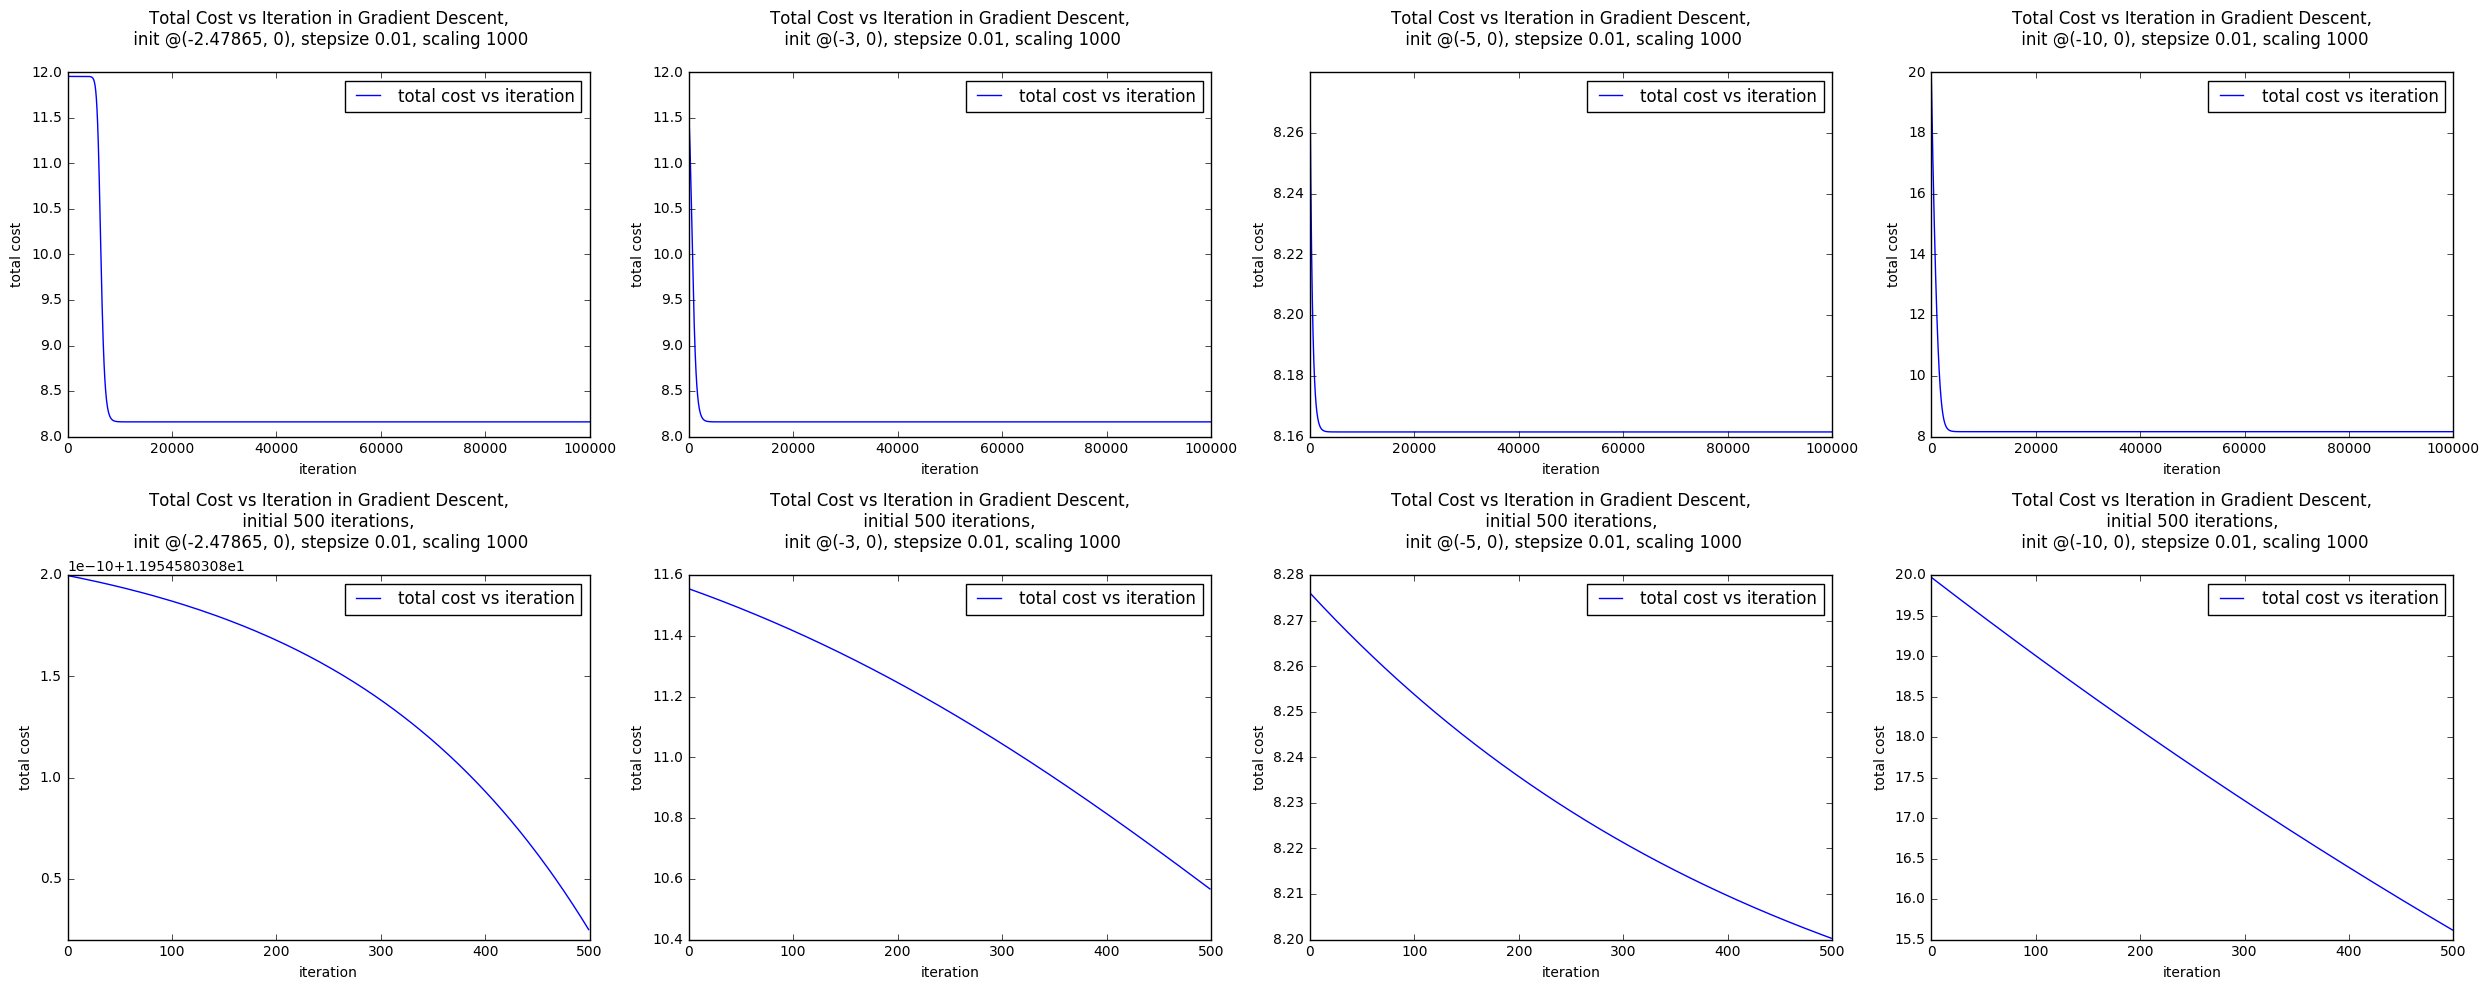

In [88]:
fig, ax = plt.subplots(2, 4, figsize=(25, 10))

lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for i in range(len(lambdas_inits)):
    history = gradient_descent(x, y, lambdas_inits[i], step_size=0.01, scaling=1000., maxsteps=100000)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)
    ax[0, i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[0, i].set_xlabel('iteration')
    ax[0, i].set_ylabel('total cost')
    ax[0, i].set_title('Total Cost vs Iteration in Gradient Descent,\n init @({}, 0), stepsize 0.01, scaling 1000\n'.format(lambdas_inits[i][0]))
    ax[0, i].legend(loc='best')
    
    ax[1, i].plot(range(len(costs[:500])), costs[:500], label='total cost vs iteration')
    ax[1, i].set_xlabel('iteration')
    ax[1, i].set_ylabel('total cost')
    ax[1, i].set_title('Total Cost vs Iteration in Gradient Descent,\n initial 500 iterations, \n init @({}, 0), stepsize 0.01, scaling 1000\n'.format(lambdas_inits[i][0]))
    ax[1, i].legend(loc='best')
    
plt.tight_layout()
plt.show()

We see that in each case, for each initial choice of lambdas, gradient descent proceeded towards the saddle point and, once having reached the saddle, remained at the saddle.

What is unexpected is the behaviour of gradient descent for the initialization (-2.47865, 0). Recall that at $(\lambda_1, \lambda_2) = (-2.47865, 0)$, the total loss function has a local max and at a local max the gradient is zero. So why doesn't gradient descent get stuck at the local max? Well, it did, for about a couple of thousands of iterations (see left-most column of graphs above). But recall that we are approximating the location of the local max with $(-2.47865, 0)$, thus the gradient at $(-2.47865, 0)$ is close to zero but not exactly zero. This means that your gradient descent algorithm maybe making microscopic progress in the parameter space and that if you let it run for long enough, it might move to a region of the space where the gradients are large again. Note that, in practice, we never let gradient descent algorithms crawl! That is, we terminate the algorithm whenever it ceases to make "large" updates to the parameters. This is because for a general complex objective function there is not always a way for us to predict how long the algorithm must run before it gets "unstuck" or converges on an acceptable solution. 

In [49]:
print 'gradient at approximate local max (-2.47865, 0):', grad(-2.47865, 0, x, y)
print 'gradient at approximate saddle (-5.36325, 0):', grad(-5.36325, 0, x, y)

gradient at approximate local max (-2.47865, 0): [  1.27466626e-05   0.00000000e+00]
gradient at approximate saddle (-5.36325, 0): [ -1.27991562e-06   0.00000000e+00]


So how will stochastic gradient descent behave around stationary points (points at which the gradient of the total loss function is zero)? Recall that stochastic gradient descent does not compute the gradient of the "real" objective function in each iteration. Rather it computes an "approximate" gradient using just one data point (i.e. it compute the gradient of the loss function at just one random point). 

In Homework #3, we discussed how this descent with "approximate" gradients can be less efficient - while gradient descent beelines for the optimal solution, stochastic gradient descent can meander in the parameter space. However, the same "noisy" trajectories stochastic gradient descent can also help us avoid getting stuck in non-optimal stationary points. The intuition is simple, at places where the total loss function has zero gradient, it is possible that a random "approximate" loss function will not have zero gradient.

Let's experiment with stochastic gradient descent for the same set of initializations in the parameter space:

In [92]:
#Stochastic Gradient Descent
def sgd(x, y, lambdas_init, init_shuffle=False, step_size=0.001, max_epochs=1, precision=1e-3, scaling=1.):
    lambdas = lambdas_init
    history = [lambdas] # to store all thetas

    counter = 0
    epochs = 0
    i = 0 #index
        
    #if you want to shuffle the data before doing descent
    if init_shuffle:
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]    
    
    #run through the data in multiple passes
    for epoch in range(max_epochs):
        #for each data point, compute the gradient and make an update to our parameters
        #print 'epoch: ', epoch 
        for i in range(N):
            #get gradient of average loss function
            gradient = grad(lambdas[0], lambdas[1], x[i], y[i])
            #take one step in the gradient direction, scaling is just a scaling factor that adjusts the stepsize
            #of course you can just directly adjust the stepsize
            lambdas = lambdas -  step_size * gradient * scaling 
            #add our new parameters to the history
            history.append(lambdas)   
            
            if np.linalg.norm(np.array(lambdas) - np.array([2.05384, 0])) < precision:
                return history, epoch
            elif np.any(np.isnan(lambdas)):
                return history[:-1], epoch
        
        #shuffle the data for the next pass thru
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]
    
    return history, max_epochs

Final cost with initialization @ (-2.47865, 0) in 8 epochs is 11.9545803086
Final cost with initialization @ (-3, 0) in 8 epochs is 8.16152869937
Final cost with initialization @ (-5, 0) in 8 epochs is 8.16152869937
Final cost with initialization @ (-10, 0) in 8 epochs is 8.16152869937


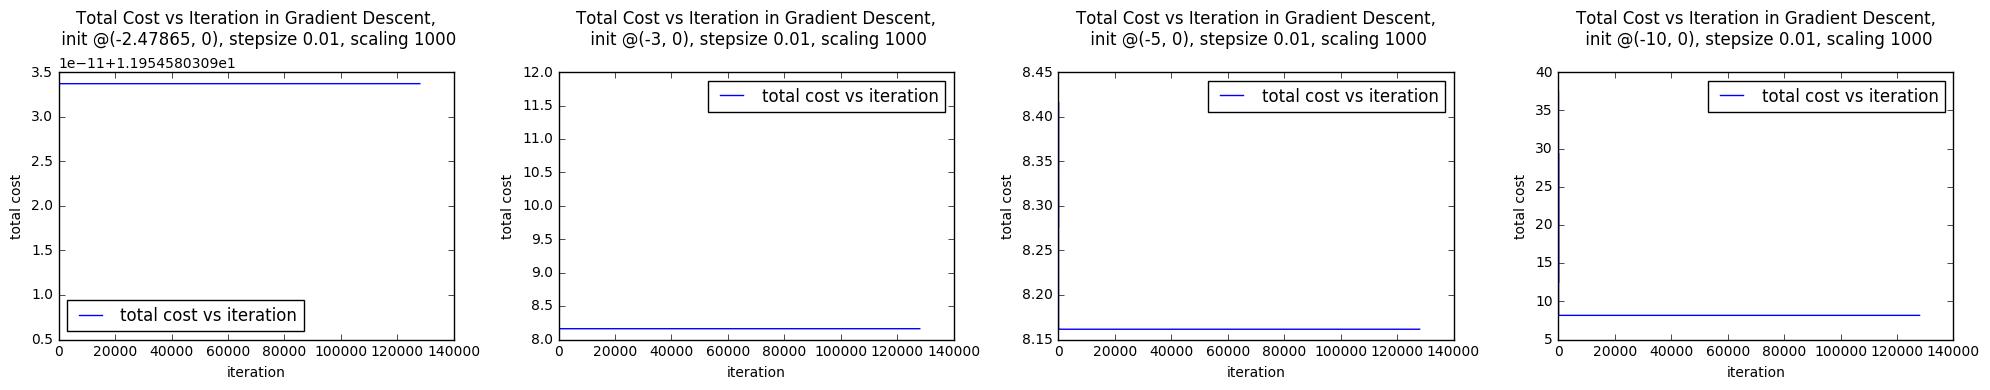

In [93]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for i in range(len(lambdas_inits)):
    history, epoch = sgd(x, y, lambdas_inits[i], init_shuffle=True, step_size=0.01, max_epochs=8, scaling=1000.)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)
    print 'Final cost with initialization @ ({}, {}) in {} epochs is {}'.format(lambdas_inits[i][0], lambdas_inits[i][1], epoch, costs[-1])
    ax[i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('total cost')
    ax[i].set_title('Total Cost vs Iteration in Gradient Descent,\n init @({}, 0), stepsize 0.01, scaling 1000\n'.format(lambdas_inits[i][0]))
    ax[i].legend(loc='best')
    
plt.tight_layout()
plt.show()

We see that with step size 0.01 and scaling factor of 1000 (or simply step size 10), stochastic gradient descent appears to do no better than gradient descent in escaping stationary points! So is our intuition about stochastic descent wrong? Well, recall that stochastic descent is very sensitive to stepsize, in particular, the "stochastic-ness" (or randomness) of the algorithm can be either amplified or diminished by the step-size. Choose sufficiently small step sizes, you may not see too much randomness in the behaviour of your SGD; choose sufficiently large step sizes, you may observe very unexpected results.

Let's increase the step size to 0.05 with scaling factor of 1000 (or simply step size 50) and see what happens:

Final cost with initialization @ (-2.47865, 0) in 0 epochs is -9.9341040044
Final cost with initialization @ (-3, 0) in 1 epochs is -9.93410318236
Final cost with initialization @ (-5, 0) in 0 epochs is -9.93410383796
Final cost with initialization @ (-10, 0) in 0 epochs is -9.93410263935


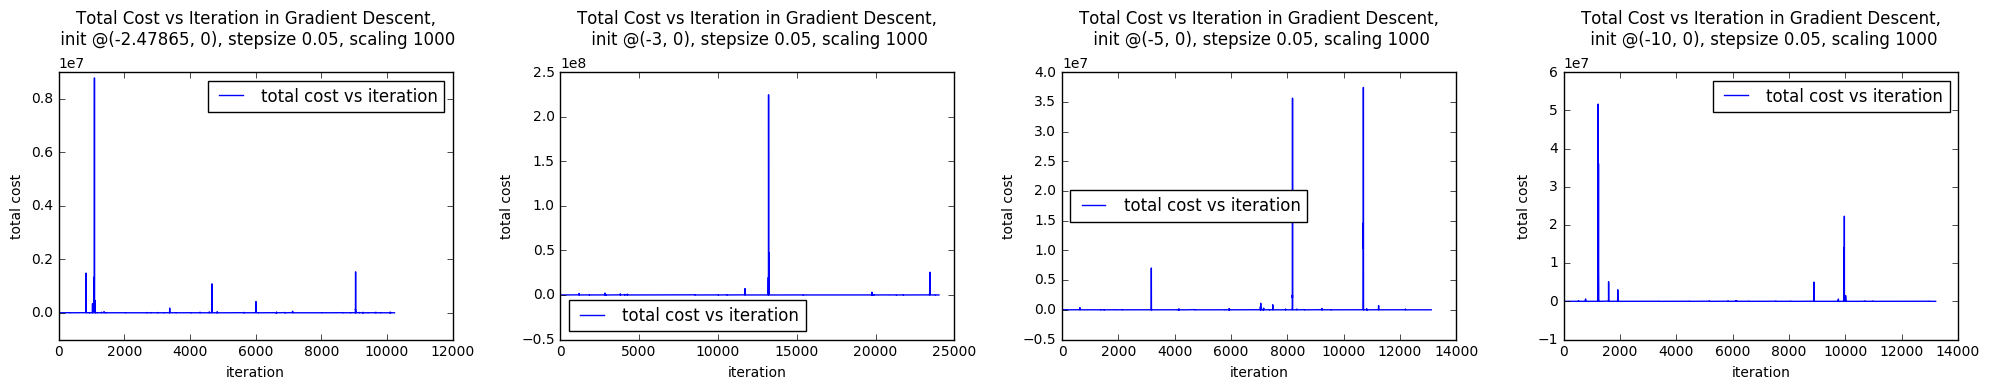

In [94]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for i in range(len(lambdas_inits)):
    history, epoch = sgd(x, y, lambdas_inits[i], init_shuffle=True, step_size=0.05, max_epochs=8, scaling=1000.)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)
    print 'Final cost with initialization @ ({}, {}) in {} epochs is {}'.format(lambdas_inits[i][0], lambdas_inits[i][1], epoch, costs[-1])
    ax[i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('total cost')
    ax[i].set_title('Total Cost vs Iteration in Gradient Descent,\n init @({}, 0), stepsize 0.05, scaling 1000\n'.format(lambdas_inits[i][0]))
    ax[i].legend(loc='best')
    
plt.tight_layout()
plt.show()

So in this case, we see that SGD is able to converge onto the correct optimum for all initial values of lambdas we chose! With an increase in the step size, we were able to amplify the randomness of the algorithm enough to help us escape stationary points! 

Now, this begs the question:

**What step size should I choose to help SGD escape undesirable stationary points?**

For example, is it true that the bigger the step-size the faster my SGD algorithm converges onto the global minimum? Let's run SGD on the same set of initial lambda values again, this time, with step size 0.5 and scaling factor 1000 (or step size 500).

Final cost with initialization @ (-2.47865, 0) in 0 epochs is inf
Final cost with initialization @ (-3, 0) in 0 epochs is inf
Final cost with initialization @ (-5, 0) in 0 epochs is inf
Final cost with initialization @ (-10, 0) in 0 epochs is inf


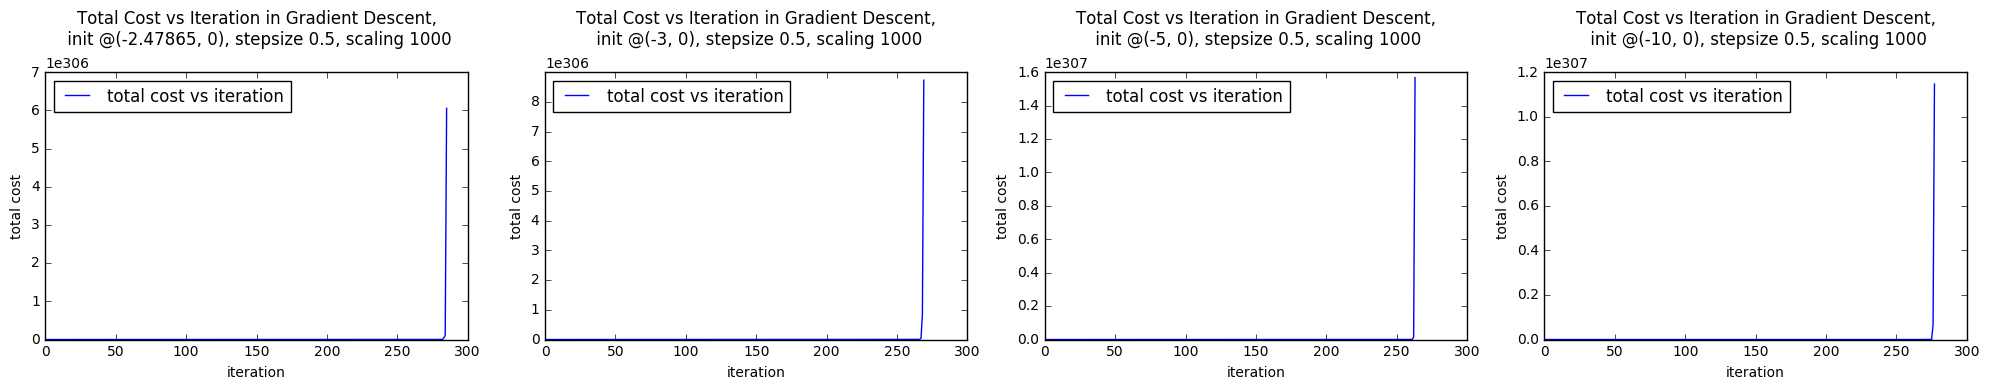

In [97]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for i in range(len(lambdas_inits)):
    history, epoch = sgd(x, y, lambdas_inits[i], init_shuffle=True, step_size=0.5, max_epochs=8, scaling=1000.)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)
    print 'Final cost with initialization @ ({}, {}) in {} epochs is {}'.format(lambdas_inits[i][0], lambdas_inits[i][1], epoch, costs[-1])
    ax[i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('total cost')
    ax[i].set_title('Total Cost vs Iteration in Gradient Descent,\n init @({}, 0), stepsize 0.5, scaling 1000\n'.format(lambdas_inits[i][0]))
    ax[i].legend(loc='best')
    
plt.tight_layout()
plt.show()

Just as we saw in Homework #3, when the step size is "large", stochastic gradient descent can have unexpected and deeply undesirable behaviours (for contrast, run gradient descent using a 0.5 step size).

### Lesson Learned:
Unlike gradient descent, which can get stuck in undesirable stationary points, the randomness of stochastic gradient descent can keep the algorithm moving towards the global optimum. But this benefit can only be realized by the correct choice of step size, for a choice of step size that is too small, the randomness of SGD (with fixed step size) is insufficient to move it out of a stationary point; for a choice of step size that is too large, the randomness of SGD (with fixed step size) may prevent the algorithm from converging or even getting close to the global optimum.

### Part B: Simulated Annealing
Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our lost function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should further experiment with and tweak these or feel free to set your own):

- Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
- Min Length: 500
- Max Temperature: 10

You should also set your own cooling schedule.

**Solutions:**

To perform simulated annealing, we just need the following ingredients:

1. an objective function, this will be our total loss function $L$
2. a proposal function, $g$ (satisfying some technical conditions)
3. a heatin/cooling schedule
4. hyperparameter settings: maximum temperature, minimum chain length at each temperature


Since our total loss function is a real-valued function in two variables ($\lambda_1$ and $\lambda_2$), we need our proposal function $g(\lambda^{new}_1, \lambda^{new}_2 | \lambda^{old}_1, \lambda^{old}_2)$ to also be a bivariate function. To keep things simple, let's choose
$$
g(\lambda^{new}_1, \lambda^{new}_2 | \lambda^{old}_1, \lambda^{old}_2) = \mathcal{N}(\lambda^{new}_1, \lambda^{new}_2; [\lambda^{old}_1, \lambda^{old}_2], \Sigma),
$$
that is, the proposal function is a normal pdf centered at the current values of lambda with covariance matrix $\Sigma$. In our case, we will set $\Sigma = \left(\begin{array}{cc} 1& 0\\ 0& 1 \end{array}\right)$

We will run the algorithm for 10 epochs, each time cooling the current temperature by 80%. At each temperature, we will let the algorithm run for 120% longer than at the previous, higher, temperature (running the algo longer at cooler temperatures will encourage convergences).

In [142]:
#Simulated Annealing
def sa(energy, init_params, epochs, reduce_temp, incr_iters, proposal):
    accumulator = []
    
    old_solution = init_params['solution']
    old_energy = energy(old_solution)
    
    temp = init_params['max_temp']
    length = init_params['min_length']
    
    accepted=0
    total=0
    
    for epoch in range(epochs):
        #print "Epoch:", epoch
        
        #decrease temperature and increase iteration length
        if epoch > 0:
            temp = reduce_temp(temp)
            length = incr_iters(length)
            
        #print "Temperature", temp, "Length", length

        for it in range(length):
            total += 1
            
            #propose new solution based on current solution
            new_solution = proposal(old_solution)
            #compute energy of new solution
            new_energy = energy(new_solution)
            
            #compute a probability for accpeting new solution
            alpha = min(1, np.exp((old_energy - new_energy) / temp))
            
            #if new solution is better, i.e. gives us lower energy, then accept
            #if new solution is not better, we flip a weighted coin and decide whether to accept
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)): 
                accepted += 1
                accumulator.append([temp, new_solution, new_energy])
                
                old_energy = new_energy
                old_solution = new_solution
                
            else:
                # Keep the old stuff
                accumulator.append([temp, old_solution, old_energy])

    return accumulator, accepted * 1. / total

In [166]:
#Proposal distribution: bivariate normal with 
Sigma = [[1, 0], [0, 1]]
proposal = lambda x: np.random.multivariate_normal(x, Sigma, 1)[0]

reduce_temp = lambda t: 0.8*t #temperature function
incr_iters = lambda length: int(math.ceil(1.2*length)) #iteration function

energy = lambda l: L(l[0], l[1], x, y)

In [167]:
lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for lambdas in lambdas_inits:
    init_params = {'solution':np.array(lambdas), 'min_length':500, 'max_temp':10}
    accumulator, accepted_ratio = sa(energy, init_params, 10, reduce_temp, incr_iters, proposal)
    print '\n******** Results for init @ ({}, {})********'.format(lambdas[1], lambdas[0])
    print 'ratio of solutions accepted: ', accepted_ratio
    accumulator_sorted = sorted(accumulator, key=lambda t: t[2])
    print 'we found the minimum of {} with parameters ({}, {}), at temperature {}'.format(accumulator_sorted[0][2], accumulator_sorted[0][1][0], accumulator_sorted[0][1][1], accumulator_sorted[0][0])


******** Results for init @ (0, -2.47865)********
ratio of solutions accepted:  0.558746535263
we found the minimum of -9.93353972748 with parameters (2.04275710499, 0.0140929160306), at temperature 2.097152

******** Results for init @ (0, -3)********
ratio of solutions accepted:  0.555743763474
we found the minimum of -9.93409288856 with parameters (2.05289003739, -0.00262719891545), at temperature 1.6777216

******** Results for init @ (0, -5)********
ratio of solutions accepted:  0.54804434863
we found the minimum of -9.93407251758 with parameters (2.0568206963, 0.00268766093241), at temperature 1.6777216

******** Results for init @ (0, -10)********
ratio of solutions accepted:  0.556744687404
we found the minimum of -9.93344170952 with parameters (2.03769281165, 0.00143961378118), at temperature 3.2768


**Conclusion:** From the above we see that, with Simulated Annealing, we were able to converge around the correct global minimum for all the initial values of lambdas that caused problems for gradient descent (and for stochastic gradient descent, up to a point).